# Simulating IFU mode and Datacubes

This page describes how to simulate IFU mode data and spectral datacubes for JWST's NIRSpec IFU and MIRI MRS.

<div class="alert alert-info">
IFU support is a relatively recent addition, and efforts are still in progress to refine and improve the fidelity of IFU mode simulations. 
</div>


## Selecting IFU mode simulations

These instruments have a `mode` attribute, which can be set to either 'IFU' or 'imaging'. Selecting IFU mode has the following effects:

 - The normal `filter` attribute for selecting spectral bandpass is superceded by a `band` attribute for selected IFU bands, the specific details of which differ for NIRSpec and MIRI. A `get_IFU_wavelengths()` function is added, which allows looking up the wavelength range for each band. 
 - The PSF simulation gets an added step for adding "IFU broadening" effects, which are empirical models for slightly broadening/blurring the simulated PSF to better match the observed PSF FWHMs. Physically this is a simplified model for optical blurring effects due to imperfect wavefront quality in the IFU image slicer optics, for example.
 - For NIRSpec IFU simulations only, the PSF output is rotated by an additional 90 degrees to match the orientation of JWST pipeline output dataproducts created with the "orient='IFUalign'" option in the Cube Build step.

Note there are *three options* for computing PSFs in IFU mode. 

1. If you only need one wavelength, use regular `calc_psf()` with the `monochromatic` keyword to specify a wavelength.
2. If you want a datacube at all wavelengths, use `calc_datacube()` with a list or array of wavelengths. This is the recommended path for many typical use cases. 
3. If you want a datacube at all wavelengths, you can also use `calc_datacube_fast()` which achieves a much-faster calculation runtime by making a simplifying assumption in the optical calculation, and currently by not including the detector effects or distortion modeling steps.
  
   *  Specifically, it assumes that the wavefront optical path difference in the IFU exit pupil is independent of wavelength. This assumption is reasonably true for both MIRI and NIRSpec IFU modes within the current level of fidelity.

## Datacube Coordinate Frames for IFU PSFs: SkyAlign vs IFUAlign

<div class="alert alert-warning">
WebbPSF is intended to simulate IFU PSFs in <I>IFUAlign</I> orientation only.
</div>

For IFU observations, the JWST pipeline ``cube_build`` step (see [pipeline docs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/cube_build/main.html)) can produce output datacubes in two different reference frames or orientations: 

 - ``coord_system='skyalign'``. In these cubes, north is up and east is left. This is the default orientation.
 - ``coord_system='ifualign'``. These cubes are build on the local IFU slicer plane's native coordinate system. The X and Y coordinates corresponds to the along-slice and across-slice directions, respectively (which are often labeled as the $\alpha$ and $\beta$ axes for MIRI MRS; see [JDox](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-mrs-field-and-coordinates#MIRIMRSFieldandCoordinates-CoordinatesMRScoordinateframes).)

<B>PSF simulations are always produced in the ifualign orientation only.</b> For PSF modeling work, we recommend reducing your science data using the ifualign frame. This allows PSF models and orientations to be consistent between multiple datasets, independent of position angles on the sky. 

If your science data has been reduced in skyalign frame, you can rotate the PSF based on the aperture position angle to match your data. However this will introduce numerical interpolation noise, particularly for spatially undersampled IFU data. That can be avoided by working in IFUalign frame, as we recommend here. 


**Pixelscales:** By default, IFU PSFs are made using the same default pixel scales as the pipeline defaults (0.1 arcsec/pixel for NIRSpec, and variously 0.13 - 0.35 arcsec/pixel for MIRI depending on which MRS channel). If you have reduced your science data using a different pixelscale in the JWST pipeline, e.g. 0.123 arcsec/pix, simply set e.g. `miri.pixelscale = 0.123` to the same value for creating the PSF model. 

In [1]:
%matplotlib inline
import webbpsf
import astropy.units as u

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-067
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


## NIRSpec IFU example

For NIRSpec, the `band` attribute is derived from the `prism` and `disperser` elements. 

In [2]:
nrs = webbpsf.NIRSpec()
nrs.mode = 'IFU'

nrs.disperser = 'PRISM'
nrs.filter = 'CLEAR'
print("Band is", nrs.band)

Band is PRISM/CLEAR


The wavelength sampling can be obtained using the `get_IFU_wavelengths()` function.  By default this returns the same wavelength sampling as the pipeline uses. But if desired you can also specify some other number of wavelengths `nlambda`, for instance to reduce simulation runtimes when the full spectral resolution is not needed. 

In [3]:
allwaves = nrs.get_IFU_wavelengths()
print(f"{nrs.band} default wavelength sampling uses {len(allwaves)} wavelengths")
allwaves

PRISM/CLEAR default wavelength sampling uses 940 wavelengths


<Quantity [0.6  , 0.605, 0.61 , 0.615, 0.62 , 0.625, 0.63 , 0.635, 0.64 ,
           0.645, 0.65 , 0.655, 0.66 , 0.665, 0.67 , 0.675, 0.68 , 0.685,
           0.69 , 0.695, 0.7  , 0.705, 0.71 , 0.715, 0.72 , 0.725, 0.73 ,
           0.735, 0.74 , 0.745, 0.75 , 0.755, 0.76 , 0.765, 0.77 , 0.775,
           0.78 , 0.785, 0.79 , 0.795, 0.8  , 0.805, 0.81 , 0.815, 0.82 ,
           0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 , 0.855, 0.86 , 0.865,
           0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895, 0.9  , 0.905, 0.91 ,
           0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 , 0.945, 0.95 , 0.955,
           0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995, 1.   ,
           1.005, 1.01 , 1.015, 1.02 , 1.025, 1.03 , 1.035, 1.04 , 1.045,
           1.05 , 1.055, 1.06 , 1.065, 1.07 , 1.075, 1.08 , 1.085, 1.09 ,
           1.095, 1.1  , 1.105, 1.11 , 1.115, 1.12 , 1.125, 1.13 , 1.135,
           1.14 , 1.145, 1.15 , 1.155, 1.16 , 1.165, 1.17 , 1.175, 1.18 ,
           1.185, 1.19 , 1.195, 1.2  ,

In [4]:
# let's get a subset for a faster PSF sim runtime
waves = nrs.get_IFU_wavelengths(nlambda=50)

# convert waves from  microns to meters
# (this is a work around for a current issue with the poppy library upstream)
waves = waves.to_value(u.meter)

Compute a datacube:

In [5]:
cube = nrs.calc_datacube(waves)

The output FITS file has the same extensions as a regular PSF calculation, but each extension contains a 3D datacube rather than a 2D image: 

In [6]:
cube.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU    1288   (192, 192, 50)   float64   
  1  DET_SAMP      1 ImageHDU      1290   (48, 48, 50)   float64   
  2  OVERDIST      1 ImageHDU      1343   (192, 192, 50)   float64   
  3  DET_DIST      1 ImageHDU      1344   (48, 48, 50)   float64   


The `calc_datacube_fast` routine does a simplified calculation, much faster: 

In [7]:
quickcube = nrs.calc_datacube_fast(waves)

Note that in this case, the output FITS file only contains the first oversampled extension:

In [8]:
quickcube.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     159   (192, 192, 50)   float64   


The display_psf function works with datacubes, but you have to specify which slice of the cube to display. 

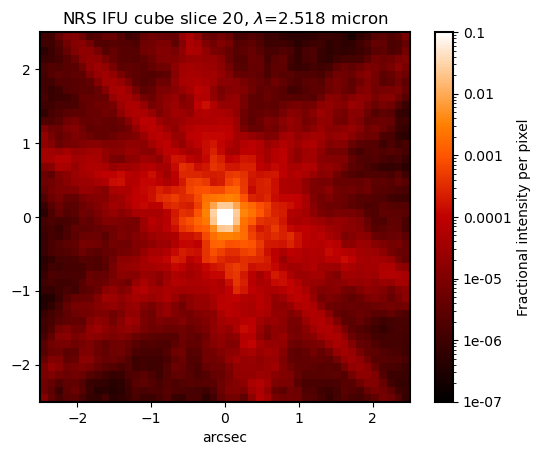

In [9]:
index = 20
webbpsf.display_psf(cube, ext=3, cube_slice=index, 
                    # Note that currently the default plot title isn't very informative for datacube modes
                    # so we can specify a better title directly here:
                    title=f'NRS IFU cube slice {index}, $\\lambda$={cube[0].header["WAVELN"+str(index)]*1e6:.4} micron') 

## MIRI MRS example

This is mostly the same, except the selection of the IFU bands is done via setting `band` directly. 


In [10]:
miri = webbpsf.MIRI()
miri.mode = 'IFU'
miri.band= '2A'  
print("Band is", miri.band)

Band is 2A


Note that selecting an IFU band automatically configures the simulated pixelscale to match the default scale used in pipeline output datacubes: 

In [11]:
print(f"Pixelscale for band {miri.band} is {miri.pixelscale} arcsec/pix")

miri.band = '3B'
print(f"Pixelscale for band {miri.band} is {miri.pixelscale} arcsec/pix")

Pixelscale for band 2A is 0.17 arcsec/pix
Pixelscale for band 3B is 0.2 arcsec/pix


In [12]:
# let's get a subset for a faster PSF sim runtime
waves = miri.get_IFU_wavelengths(nlambda=50)

# convert waves from  microns to meters
# (this is a work around for a current issue with the poppy library upstream)
waves = waves.to_value(u.meter)

Compute a datacube:

(Note, for MIRI MRS you may see a warning message about the valid region of the field dependence model; this is a benign warning and can be mostly ignored.)

In [13]:
cube = miri.calc_datacube(waves)

/Users/mperrin/Dropbox (Personal)/Documents/software/webbpsf/webbpsf/opds.py:1759: UserWarning: For (V2,V3) = [-8.40143167 -5.31995333] arcmin, Field point -8.254199999999999 arcmin, -2.4800466666666674 arcmin not within valid region for field dependence model of OTE WFE for MIRI: -8.254199999999999 arcmin--6.21738 arcmin, -2.557224 arcmin--0.5632056 arcmin.  Clipping to closest available valid location, 0.14723166666666643 arcmin away from the requested coordinates.
  warnings.warn(warning_message)


The output FITS file has the same extensions as a regular PSF calculation, but each extension contains a 3D datacube rather than a 2D image: 

In [14]:
cube.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     990   (240, 240, 50)   float64   
  1  DET_SAMP      1 ImageHDU       992   (60, 60, 50)   float64   
  2  OVERDIST      1 ImageHDU      1097   (240, 240, 50)   float64   
  3  DET_DIST      1 ImageHDU      1098   (60, 60, 50)   float64   


The display_psf function works with datacubes, but you have to specify which slice of the cube to display. 

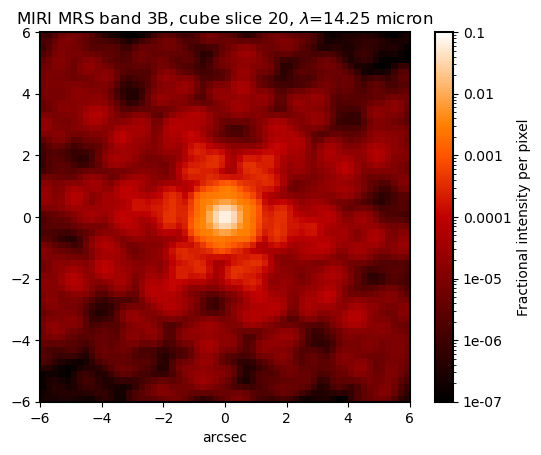

In [15]:
index = 20
webbpsf.display_psf(cube, ext=3, cube_slice=index, 
                    # Note that currently the default plot title isn't very informative for datacube modes
                    # so we can specify a better title directly here:
                    title=f'MIRI MRS band {miri.band}, cube slice {index}, $\\lambda$={cube[0].header["WAVELN"+str(index)]*1e6:.4} micron') 